#Ohad Jaegerman and Nikita Nedostoup

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ranksums, mannwhitneyu
from scipy.stats import ttest_rel
import seaborn as sns

In [2]:
# Install library
!pip install scikit-posthocs
!pip install openpyxl

In [3]:
# Load the football_data file from Kagl
# Upload from GitHub
url = 'https://raw.githubusercontent.com/VigaNik/HomeWinAnalysis-StatisticTheory-/main/results_new.xlsx'

# Read the data into a DataFrame
data = pd.read_excel(url, engine='openpyxl')

# Convert the date column to string
data['date'] = data['date'].astype(str)

# Calculate the differences between home scores and away scores
data['score_difference'] = data['home_score'] - data['away_score']


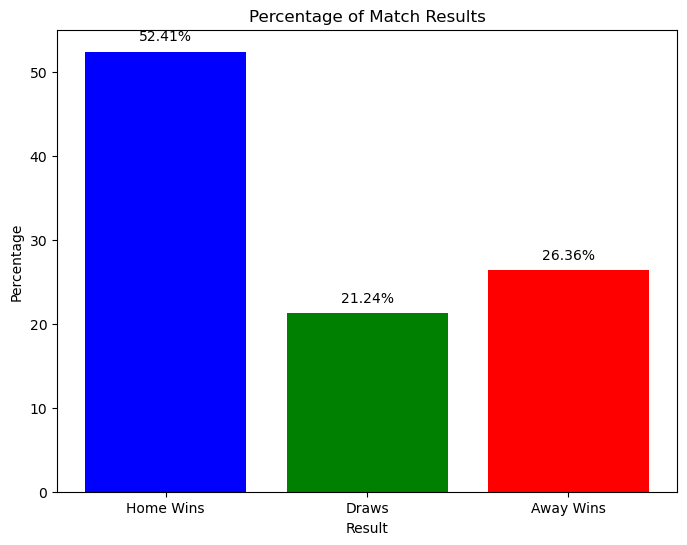

In [4]:
# Calculate the percentages
total_matches = len(data)

home_wins = len(data[data['home_score'] > data['away_score']])
draws = len(data[data['home_score'] == data['away_score']])
away_wins = len(data[data['home_score'] < data['away_score']])

home_wins_percentage = (home_wins / total_matches) * 100
draws_percentage = (draws / total_matches) * 100
away_wins_percentage = (away_wins / total_matches) * 100

# Create df for the percentages
percentages_df = pd.DataFrame({
    'Result': ['Home Wins', 'Draws', 'Away Wins'],
    'Percentage': [home_wins_percentage, draws_percentage, away_wins_percentage]
})
# Plotting the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(percentages_df['Result'], percentages_df['Percentage'], color=['blue', 'green', 'red'])
ax.set_title('Percentage of Match Results')
ax.set_xlabel('Result')
ax.set_ylabel('Percentage')
for i in range(len(percentages_df)):
    ax.text(i, percentages_df['Percentage'][i] + 1, f"{percentages_df['Percentage'][i]:.2f}%", ha='center', va='bottom')
plt.show()

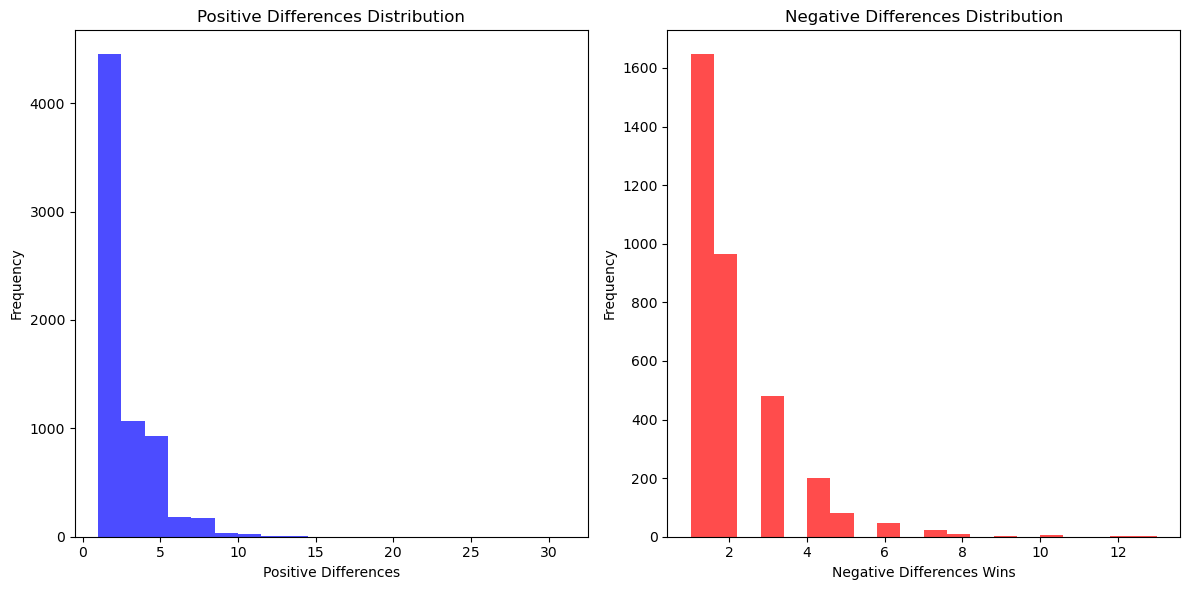

Positive Differences Normality Test: ShapiroResult(statistic=0.7416278719902039, pvalue=0.0)
Negative Differences Normality Test: ShapiroResult(statistic=0.7342570424079895, pvalue=0.0)


C:\Users\Nikita\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [5]:
# Heare we cheked if 'home win' and 'away win' colums have normal distributions
# Extract home and away scores
positive_differences = data['positive difference']
negative_differences = data['negative difference']

# Filter out zero values
positive_differences_no_zero = positive_differences[positive_differences != 0]
negative_differences_no_zero = negative_differences[negative_differences != 0]

# Ploting histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(positive_differences_no_zero, bins=20, color='blue', alpha=0.7)
plt.title('Positive Differences Distribution')
plt.xlabel('Positive Differences')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(negative_differences_no_zero, bins=20, color='red', alpha=0.7)
plt.title('Negative Differences Distribution')
plt.xlabel('Negative Differences Wins')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Performing normality tests by using Shapiro-Wilk test
positive_differences_normality = stats.shapiro(positive_differences_no_zero)
negative_differences_normality = stats.shapiro(negative_differences_no_zero)

print("Positive Differences Normality Test:", positive_differences_normality)
print("Negative Differences Normality Test:", negative_differences_normality)


C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mann-Whitney U Test results:
Statistic: 13558987.0
P-value: 1.0625274284150907e-33


C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


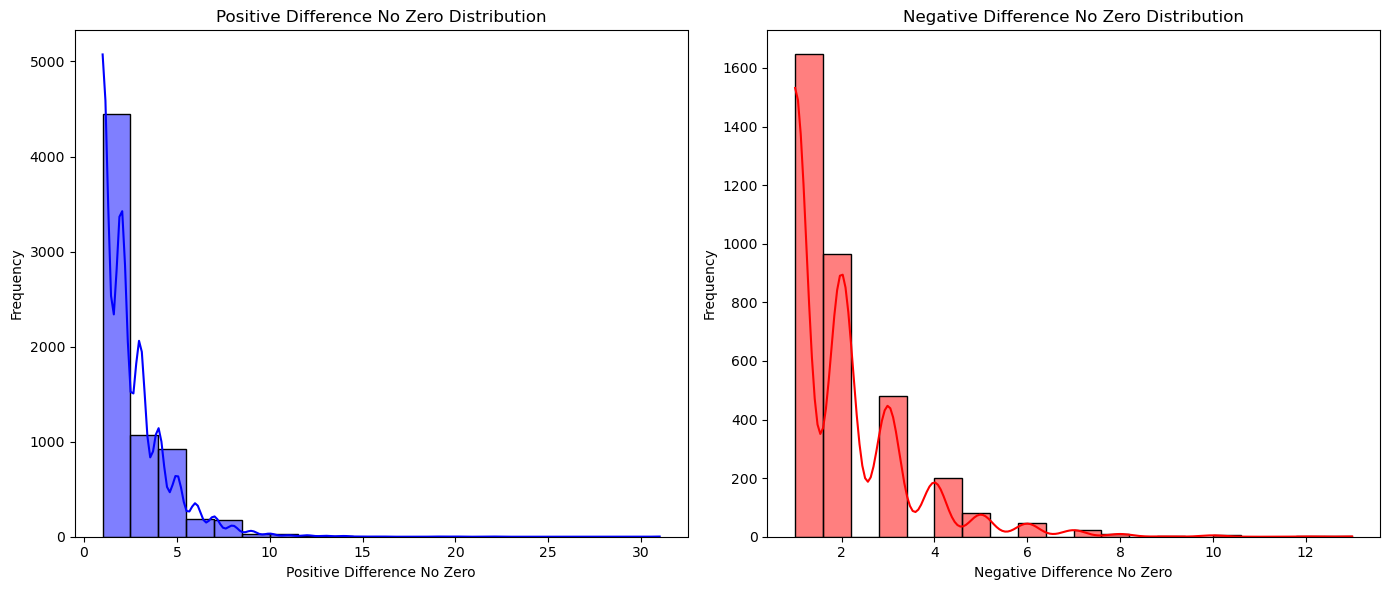

C:\Users\Nikita\AppData\Local\Temp\ipykernel_3952\1810438767.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(positive_differences_no_zero, shade=True, color="blue", label="Positive Difference No Zero")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikita\AppData\Local\Temp\ipykernel_3952\1810438767.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(negative_differences_no_zero, shade=True, color="red", label="Negative Difference No Zero")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: Fu

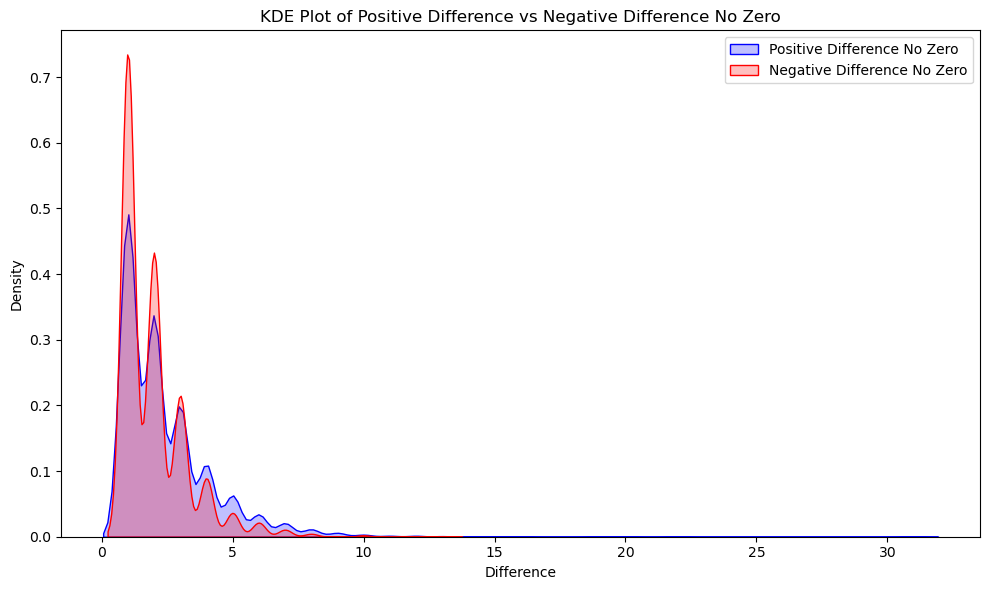

In [6]:
# 'positive difference' and 'negative difference' are the columns we want to compare
positive_differences = data['positive difference']
negative_differences = data['negative difference']

# Filter out zero values
positive_differences_no_zero = positive_differences[positive_differences != 0]
negative_differences_no_zero = negative_differences[negative_differences != 0]

# Mann-Whitney U Test
stat, p_value = mannwhitneyu(positive_differences_no_zero, negative_differences_no_zero)

# Print results
print(f"Mann-Whitney U Test results:\nStatistic: {stat}\nP-value: {p_value}")

# Plotting histograms
plt.figure(figsize=(14, 6))

# Histogram for Positive Difference
plt.subplot(1, 2, 1)
sns.histplot(positive_differences_no_zero, kde=True, color='blue', bins=20)
plt.title('Positive Difference No Zero Distribution')
plt.xlabel('Positive Difference No Zero')
plt.ylabel('Frequency')

# Histogram for Negative Difference
plt.subplot(1, 2, 2)
sns.histplot(negative_differences_no_zero, kde=True, color='red', bins=20)
plt.title('Negative Difference No Zero Distribution')
plt.xlabel('Negative Difference No Zero')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plotting Kernel Density Estimate
plt.figure(figsize=(10, 6))

sns.kdeplot(positive_differences_no_zero, shade=True, color="blue", label="Positive Difference No Zero")
sns.kdeplot(negative_differences_no_zero, shade=True, color="red", label="Negative Difference No Zero")

plt.title('KDE Plot of Positive Difference vs Negative Difference No Zero')
plt.xlabel('Difference')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

Wilcoxon rank-sum test results:
Statistic: -11.513026971729905
P-value: 5.671298356020451e-31
Mean of positive rankings (without zeros): 5410.455972101134
Mean of negative rankings (without zeros): 4694.446836174516


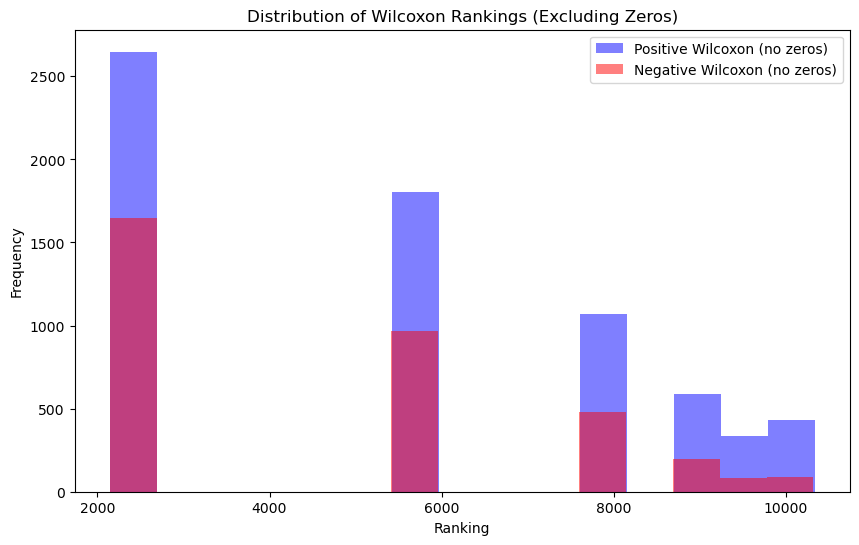

In [7]:
# Load the data
wilcoxon_df = r'C:\Users\Nikita\STproject\wilcoxon_results.xlsx'  
data_wilcoxon = pd.read_excel(wilcoxon_df)

# Use the correct columns positive wilcoson and negative wilcoson created by goal runking  
rankings_positive = data_wilcoxon['positive wilcoson']
rankings_negative = data_wilcoxon['negative wilcoson']

# Filter out zero values
rankings_positive_no_zero = rankings_positive[rankings_positive != 0]
rankings_negative_no_zero = rankings_negative[rankings_negative != 0]

# Wilcoxon rank-sum test
stat, p_value = ranksums(rankings_negative_no_zero.dropna(), rankings_positive_no_zero.dropna(), alternative='less')

# Calculate means
mean_positive = rankings_positive_no_zero.mean()
mean_negative = rankings_negative_no_zero.mean()

# Print results an plot
print(f"Wilcoxon rank-sum test results:\nStatistic: {stat}\nP-value: {p_value}")
print(f"Mean of positive rankings (without zeros): {mean_positive}")
print(f"Mean of negative rankings (without zeros): {mean_negative}")

# Ploting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram for positive and negative rankings with no 0
ax.hist(rankings_positive_no_zero, bins=15, alpha=0.5, label='Positive Wilcoxon (no zeros)', color='blue')
ax.hist(rankings_negative_no_zero, bins=15, alpha=0.5, label='Negative Wilcoxon (no zeros)', color='red')
ax.set_title('Distribution of Wilcoxon Rankings (Excluding Zeros)')
ax.set_xlabel('Ranking')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

Paired T-test results (without zeros):
T-statistic: 17.096445376496348
P-value: 7.54612906842305e-64
Mean of positive differences (without zeros): 2.06856716974101
Mean of negative differences (without zeros): 1.6515744363704117


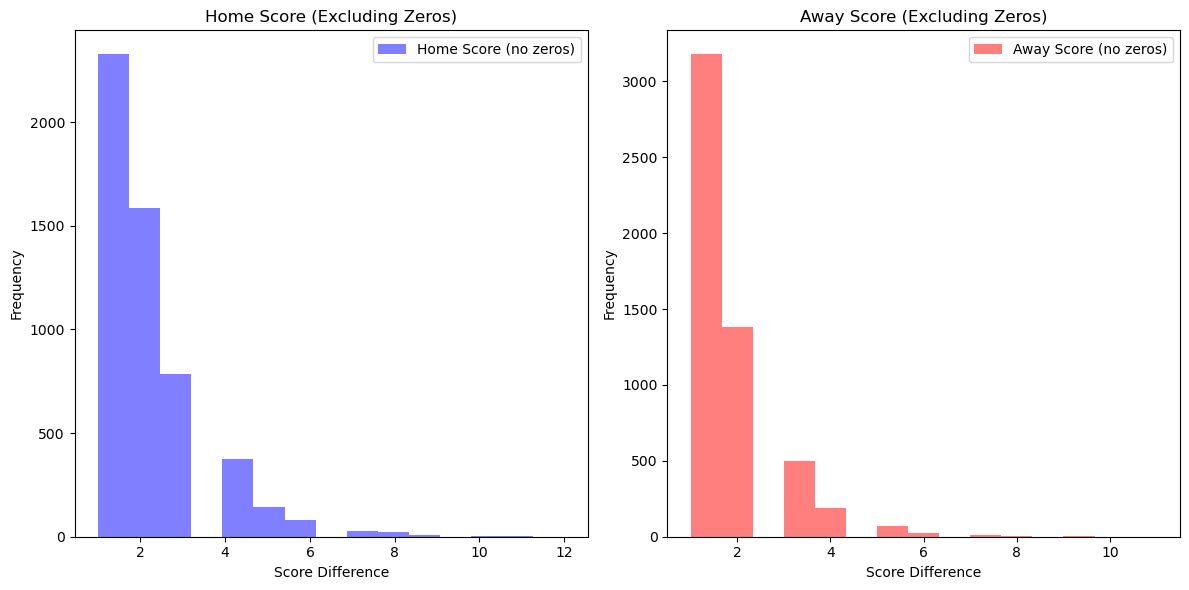

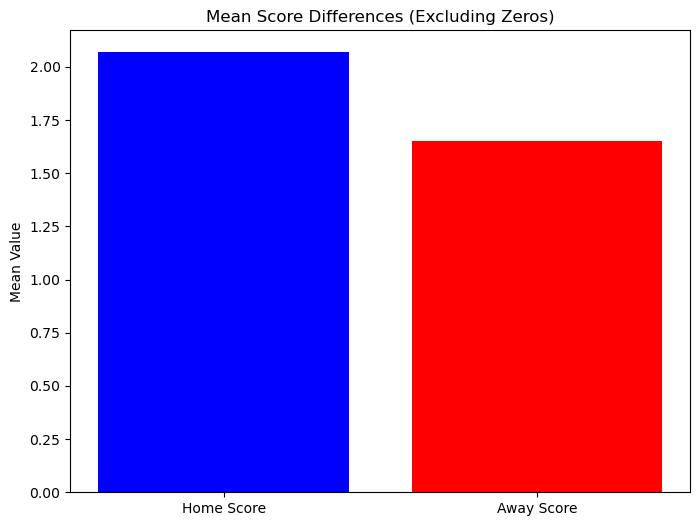

In [8]:
# Separate the positive and negative differences into two series
home_score = data['home_score']
away_scor = data['away_score']

# Align the data to ensure pairs are maintained and filter out zero values
aligned_data = pd.DataFrame({'positive': home_score, 'negative': away_scor})
aligned_data = aligned_data[(aligned_data['positive'] != 0) & (aligned_data['negative'] != 0)]

# Paired T-test
t_stat_no_zero, p_value_no_zero = ttest_rel(aligned_data['positive'], aligned_data['negative'])

# Calculate means without zeros
mean_positive_no_zero = aligned_data['positive'].mean()
mean_negative_no_zero = aligned_data['negative'].mean()

# Print paired T-test results and means
print(f"Paired T-test results (without zeros):\nT-statistic: {t_stat_no_zero}\nP-value: {p_value_no_zero}")
print(f"Mean of positive differences (without zeros): {mean_positive_no_zero}")
print(f"Mean of negative differences (without zeros): {mean_negative_no_zero}")

# Ploting the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for positive differences without zeros
ax[0].hist(aligned_data['positive'], bins=15, alpha=0.5, label='Home Score (no zeros)', color='blue')
ax[0].set_title('Home Score (Excluding Zeros)')
ax[0].set_xlabel('Score Difference')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Histogram for negative differences without zeros
ax[1].hist(aligned_data['negative'], bins=15, alpha=0.5, label='Away Score (no zeros)', color='red')
ax[1].set_title('Away Score (Excluding Zeros)')
ax[1].set_xlabel('Score Difference')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.tight_layout()
plt.savefig('paired_ttest_histograms.png')
plt.show()

# Bar chart for means
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Home Score', 'Away Score']
means = [mean_positive_no_zero, mean_negative_no_zero]

ax.bar(categories, means, color=['blue', 'red'])
ax.set_title('Mean Score Differences (Excluding Zeros)')
ax.set_ylabel('Mean Value')

plt.savefig('mean_score_differences_comparison.png')
plt.show()


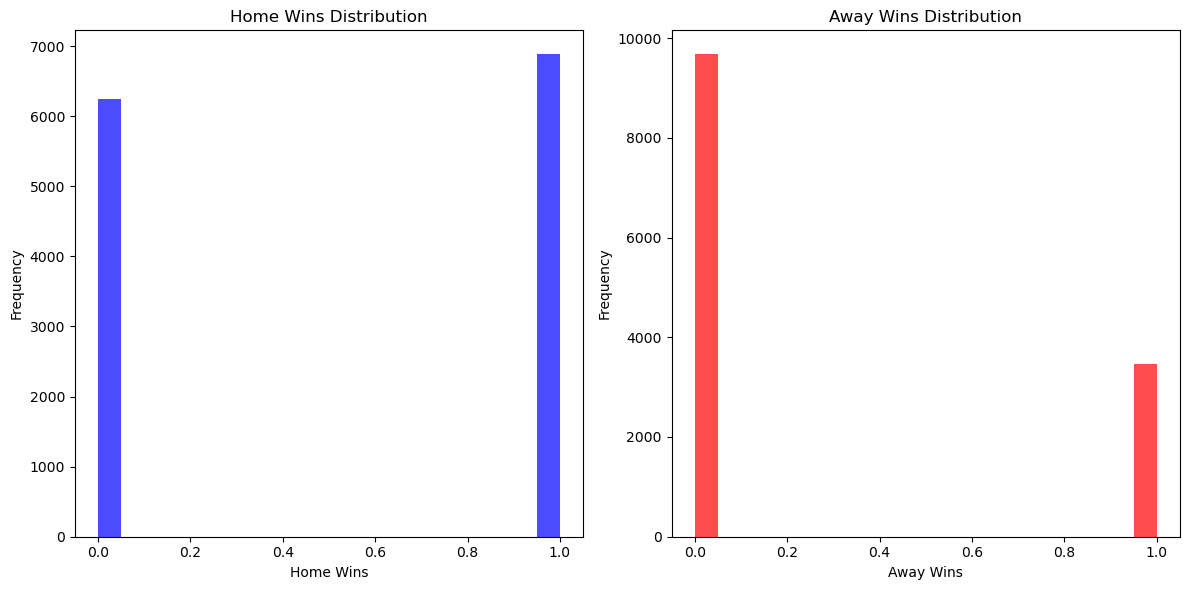

Home Win Normality Test: ShapiroResult(statistic=0.6357088685035706, pvalue=0.0)
Away Win Normality Test: ShapiroResult(statistic=0.5497009754180908, pvalue=0.0)


C:\Users\Nikita\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
# Heare we cheked if 'home win' and 'away win' colums have normal distributions
# Extract home and away scores
home_win = data['home win']
away_win = data['away win']

# Ploting histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(home_win, bins=20, color='blue', alpha=0.7)
plt.title('Home Wins Distribution')
plt.xlabel('Home Wins')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(away_win, bins=20, color='red', alpha=0.7)
plt.title('Away Wins Distribution')
plt.xlabel('Away Wins')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Perform normality tests using Shapiro-Wilk test
home_win_normality = stats.shapiro(home_win)
away_win_normality = stats.shapiro(away_win)

print("Home Win Normality Test:", home_win_normality)
print("Away Win Normality Test:", away_win_normality)


Mann-Whitney U Test results (One-Sided):
Statistic: 63762426.0
P-value: 0.0


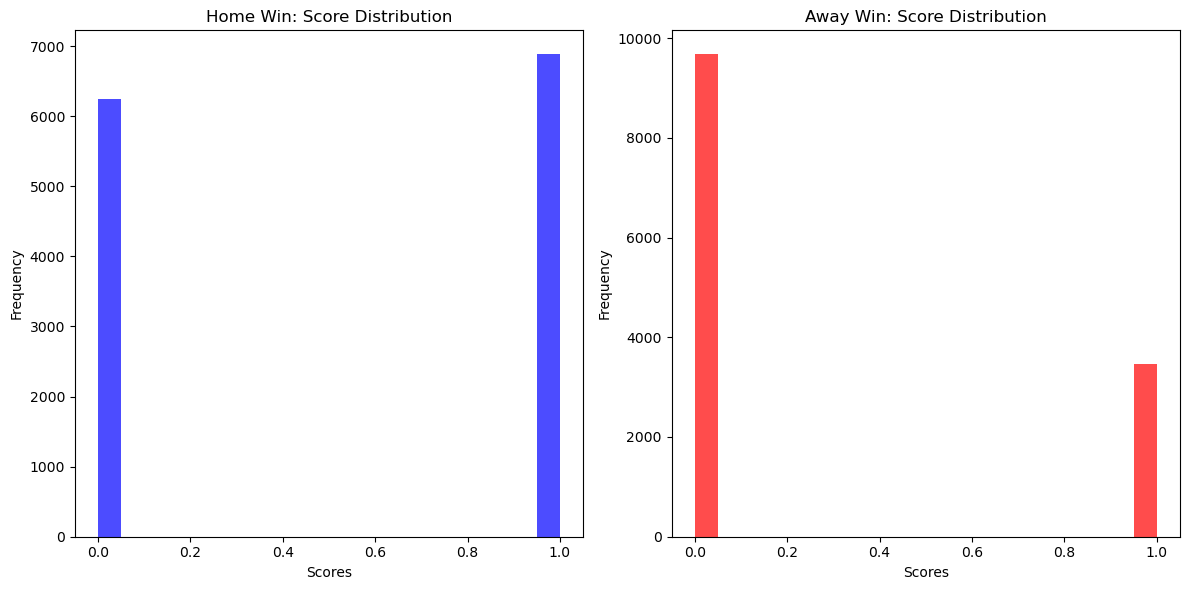

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

# 'home win' and 'away win' are the columns we want to compare
home_win = data['home win']
away_win = data['away win']

# Perform one-sided Mann-Whitney U Test
stat, p_value = mannwhitneyu(away_win, home_win, alternative='less')

print(f"Mann-Whitney U Test results (One-Sided):\nStatistic: {stat}\nP-value: {p_value}")

# Create subplots with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Ploting the histogram for Home Wins and Away Wins
ax[0].hist(home_win, bins=20, alpha=0.7, color='blue')
ax[0].set_title('Home Win: Score Distribution')
ax[0].set_xlabel('Scores')
ax[0].set_ylabel('Frequency')

ax[1].hist(away_win, bins=20, alpha=0.7, color='red')
ax[1].set_title('Away Win: Score Distribution')
ax[1].set_xlabel('Scores')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


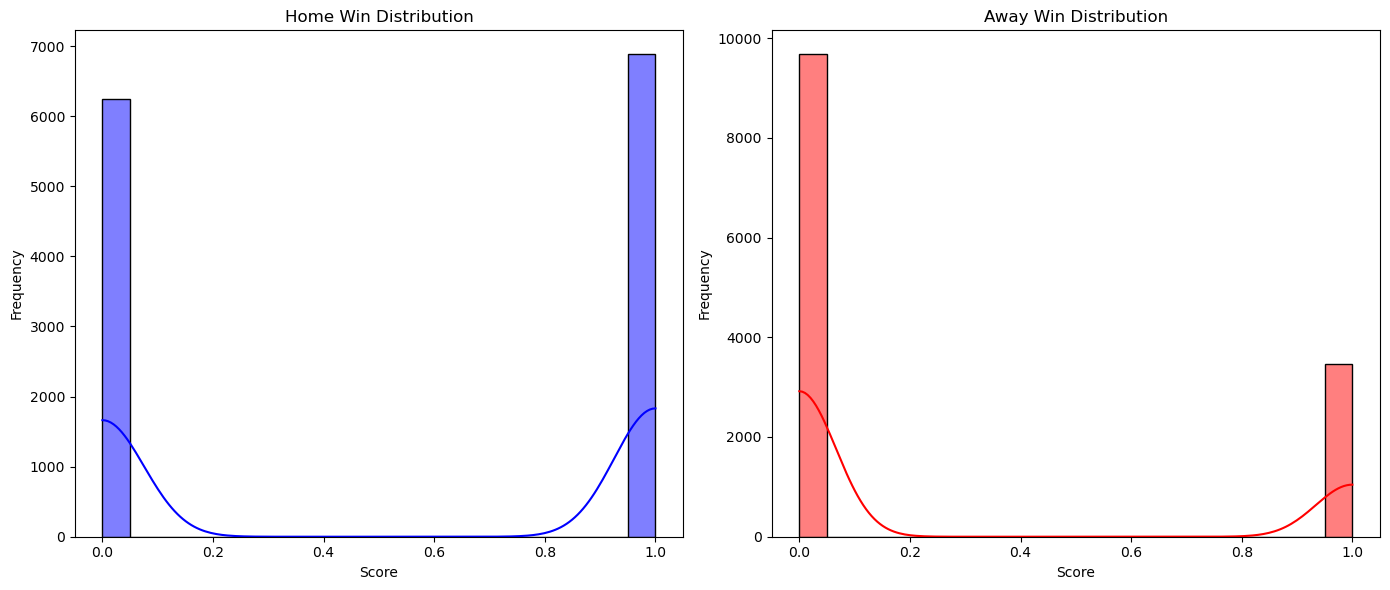

C:\Users\Nikita\AppData\Local\Temp\ipykernel_3952\388551976.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(home_win, shade=True, color="blue", label="Home Win")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikita\AppData\Local\Temp\ipykernel_3952\388551976.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(away_win, shade=True, color="red", label="Away Win")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future 

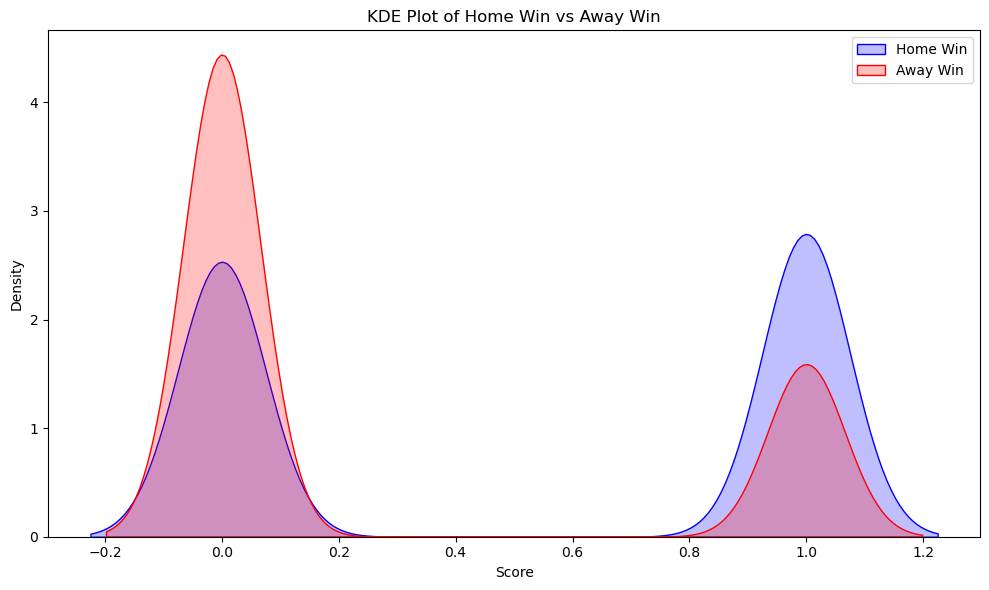

In [11]:
# 'home win' and 'away win' are the columns we want to compare
home_win = data['home win']
away_win = data['away win']

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Home Win': home_win,
    'Away Win': away_win
})

# Plotting histogram for Home win and Away win
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(home_win, kde=True, color='blue', bins=20)
plt.title('Home Win Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(away_win, kde=True, color='red', bins=20)
plt.title('Away Win Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plotting Kernel Density Estimate (KDE) plots
plt.figure(figsize=(10, 6))

sns.kdeplot(home_win, shade=True, color="blue", label="Home Win")
sns.kdeplot(away_win, shade=True, color="red", label="Away Win")

plt.title('KDE Plot of Home Win vs Away Win')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

Kruskal-Wallis Test Statistic: 44.22984635508561
P-value: 2.993028854939029e-06


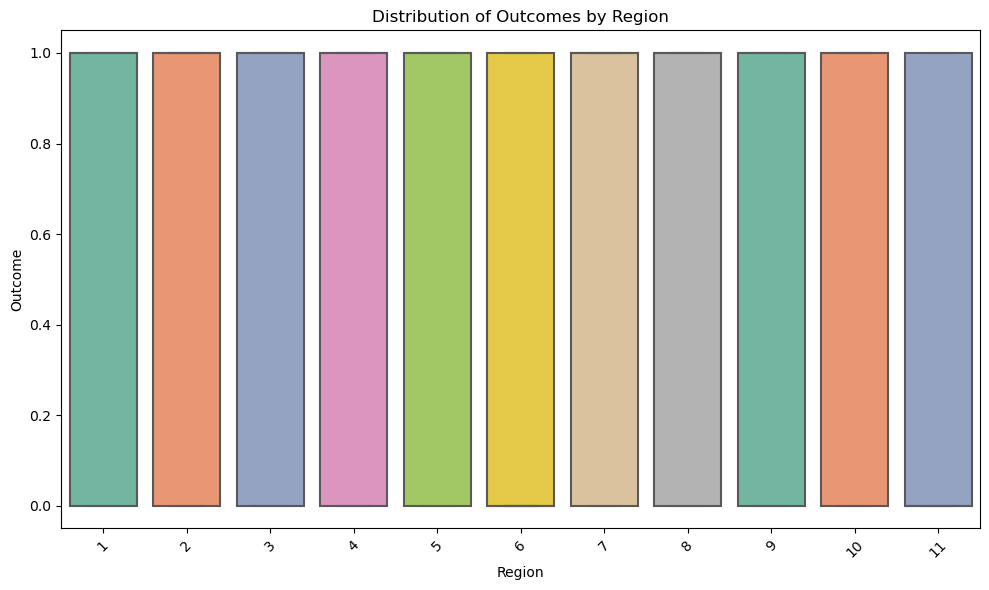

In [12]:
import pandas as pd
from scipy.stats import kruskal

# 'region' represents different regions and 'outcome' is the outcome variable
competition = data['competition']  
outcome = data['home win'] 
# Prepare the data
competition_data = [outcome[competition == region] for region in competition.unique()]

# Performing the Kruskal-Wallis test
stat, p_value = kruskal(*competition_data)

# Print the results
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Plot the distributions of outcomes by group
plt.figure(figsize=(10, 6))
sns.boxplot(x=competition, y=outcome, palette="Set2")
plt.title('Distribution of Outcomes by Region')
plt.xlabel('Region')
plt.ylabel('Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

          1    2         3         4         5    6    7         8    9    10  \
1   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  0.469084  1.0  1.0   
2   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
3   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
4   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
5   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  0.041966  1.0  1.0   
6   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
7   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
8   0.469084  1.0  1.000000  1.000000  0.041966  1.0  1.0  1.000000  1.0  1.0   
9   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
10  1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
11  0.009136  1.0  0.980178  0.498374  0.000034  1.0  1.0  0.318192  1.0  1.0   

          11  
1   0.009136

<Figure size 1200x600 with 0 Axes>

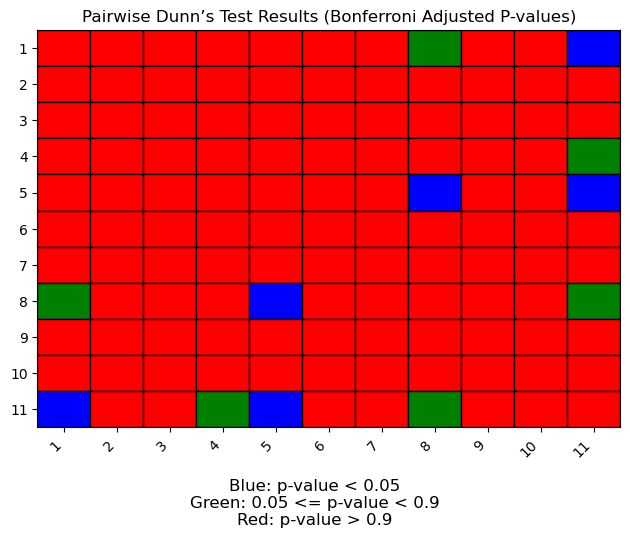

In [13]:
import pandas as pd
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap


# If significant, perform post-hoc Dunn's test
if p_value < 0.05:

    # Melt the data to fit the structure required by the test
    df_melt = pd.melt(data, id_vars=['competition'], value_vars=['home win'])

    # Perform Dunn's post-hoc test
    posthoc = sp.posthoc_dunn(df_melt, val_col='value', group_col='competition', p_adjust='bonferroni')

    # Display the pairwise p-values
    print(posthoc)

    # Define a custom color map function based on the p-value ranges
    def custom_cmap(value):
        if value < 0.05:
            return 'blue'
        elif 0.05 <= value < 0.9:
            return 'green'
        else:
            return 'red'

    # Apply the custom color map to each p-value in the posthoc matrix
    matrix = posthoc.values
    color_matrix_manual = []

    for row in matrix:
        color_row = []
        for value in row:
            color_row.append(custom_cmap(value))
        color_matrix_manual.append(color_row)
        
    # Ploting the distributions
    plt.figure(figsize=(12, 6))

    # Ploting the matrix manually
    fig, ax = plt.subplots()

    # Each cell its corresponding color and adding grid lines
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, edgecolor='black', facecolor=color_matrix_manual[i][j]))

    # Set ticks and labels
    ax.set_xticks(np.arange(len(posthoc.columns)) + 0.5, minor=False)
    ax.set_yticks(np.arange(len(posthoc.index)) + 0.5, minor=False)
    ax.set_xticklabels(posthoc.columns, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(posthoc.index, fontsize=10)

    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    ax.set_xlim(0, len(matrix))
    ax.set_ylim(0, len(matrix))
    ax.invert_yaxis()  # To match the matrix row order

    # Explanation for each color
    blue_patch = plt.Rectangle((0, 0), 1, 1, facecolor="blue", edgecolor="black")
    green_patch = plt.Rectangle((0, 0), 1, 1, facecolor="green", edgecolor="black")
    red_patch = plt.Rectangle((0, 0), 1, 1, facecolor="red", edgecolor="black")
    
    plt.figtext(0.5, -0.1, 'Blue: p-value < 0.05\nGreen: 0.05 <= p-value < 0.9\nRed: p-value > 0.9', 
                wrap=True, horizontalalignment='center', fontsize=12)

    plt.title('Pairwise Dunn’s Test Results (Bonferroni Adjusted P-values)')
    plt.tight_layout()
    plt.show()

else:
    print("No significant difference found in Kruskal-Wallis test, so no post-hoc analysis is necessary.")


C:\Users\Nikita\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Home First Goal Normality Test: ShapiroResult(statistic=0.6229138970375061, pvalue=0.0)
Away First Goal Normality Test: ShapiroResult(statistic=0.6230895519256592, pvalue=0.0)
Wilcoxon Signed-Rank Test Statistic: 61591068.0
P-value: 1.4974167158565043e-117
Reject H₀: There is a significant difference, the home team has a higher chance of scoring the first goal.


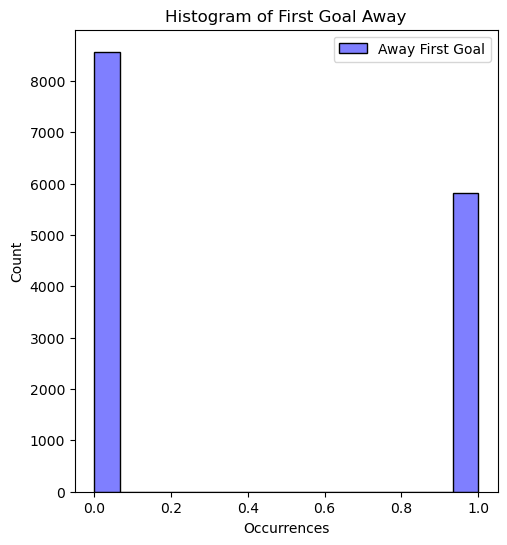

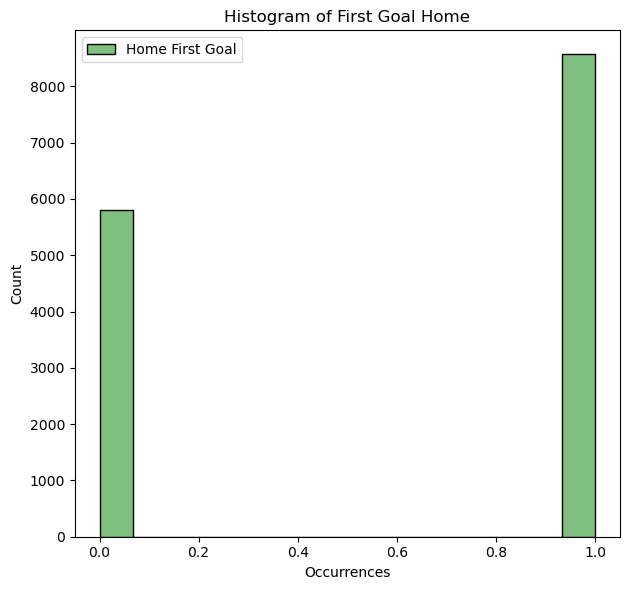

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, shapiro

# Load data with goals
# Upload from GitHub
url_goals = 'https://raw.githubusercontent.com/VigaNik/HomeWinAnalysis-StatisticTheory-/main/goalscorersN.csv'
# Read the CSV data into a df
data_goals = pd.read_csv(url_goals)

# Filter rows where 'first goal' equals 1
filtered_data = data_goals[data_goals['first goal'] == 1]

# 'first goal home' and 'first goal away' are the columns we compare
home_first_goal = filtered_data['first goal home']
away_first_goal = filtered_data['first goal away']  

# Check if the columns have non-normal distributions using the Shapiro-Wilk test
distribution_home = shapiro(home_first_goal)
distribution_away = shapiro(away_first_goal)

print(f"Home First Goal Normality Test: {distribution_home}")
print(f"Away First Goal Normality Test: {distribution_away}")

# Perform the one-sided Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(home_first_goal, away_first_goal, alternative='greater')

print(f"Wilcoxon Signed-Rank Test Statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject H₀: There is a significant difference, the home team has a higher chance of scoring the first goal.")
else:
    print("Fail to reject H₀: There is no significant difference, or the away team has an equal or higher chance.")

# # Histogram plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.histplot(away_first_goal, color='blue', label='Away First Goal', alpha=0.5, multiple='dodge')
plt.title('Histogram of First Goal Away')
plt.xlabel('Occurrences')
plt.legend()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.histplot(home_first_goal, color='green', label='Home First Goal', alpha=0.5, multiple='dodge')
plt.title('Histogram of First Goal Home')
plt.xlabel('Occurrences')
plt.legend()

plt.tight_layout()
plt.show()

Kruskal-Wallis Test Statistic: 22.674254974438696
P-value: 4.721468069868986e-05
Performing Dunn's post-hoc test...


C:\Users\Nikita\AppData\Local\Temp\ipykernel_3952\2794202703.py:46: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  color_matrix_manual = posthoc.applymap(lambda x: 'blue' if x < 0.05 else ('green' if 0.05 <= x <= 0.9 else 'red'))


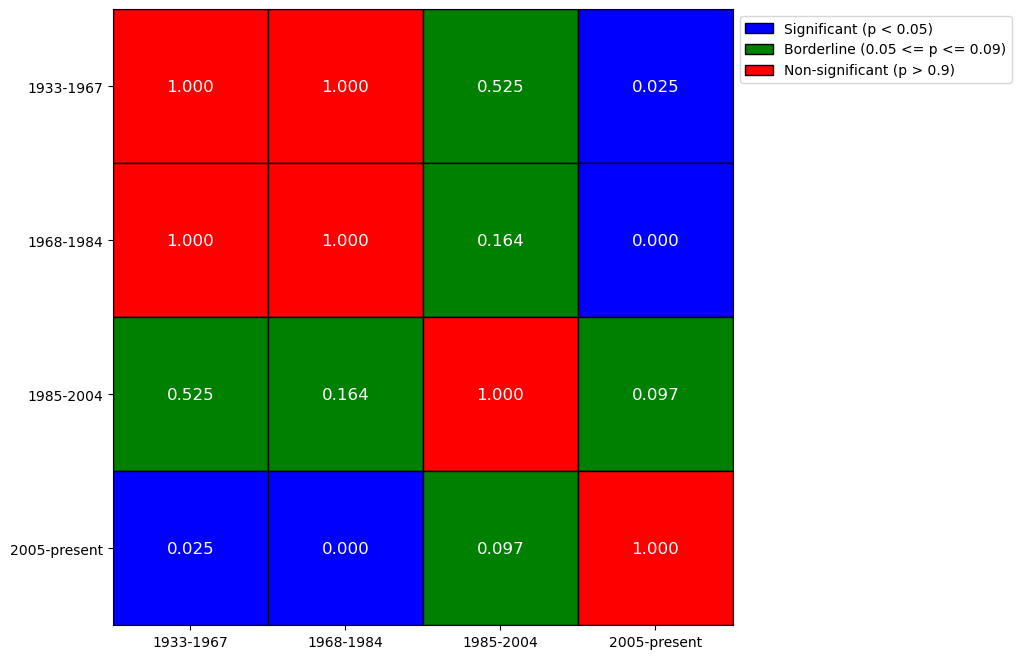

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp
import seaborn as sns


# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Filter the data for the different time periods
period1 = data[(data['date'] >= '1933-06-11') & (data['date'] <= '1967-12-31')].copy()
period2 = data[(data['date'] >= '1965-01-01') & (data['date'] <= '1984-12-31')].copy()
period3 = data[(data['date'] >= '1985-01-01') & (data['date'] <= '2004-12-31')].copy()
period4 = data[(data['date'] >= '2005-01-01') & (data['date'] <= pd.Timestamp.now())].copy()

# Combine the data
period1['period'] = '1933-1967'
period2['period'] = '1968-1984'
period3['period'] = '1985-2004'
period4['period'] = '2005-present'

combined_data = pd.concat([period1, period2, period3, period4])

outcome_column = 'home win'  

# Kruskal-Wallis test
stat, p_value = kruskal(period1[outcome_column], period2[outcome_column], period3[outcome_column], period4[outcome_column])

# Print the Kruskal-Wallis test results
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Performing Dunn's post-hoc test...")

    # Dunn's post-hoc test
    posthoc = sp.posthoc_dunn(combined_data, val_col=outcome_column, group_col='period', p_adjust='bonferroni')

    # Creating the grid plot with period labels and Dunn's test p-values
    periods = ['1933-1967', '1968-1984', '1985-2004', '2005-present']

    fig, ax = plt.subplots(figsize=(8, 8))

    color_matrix_manual = posthoc.applymap(lambda x: 'blue' if x < 0.05 else ('green' if 0.05 <= x <= 0.9 else 'red'))

    # Ploting each cell with its corresponding color and adding grid lines
    for i in range(len(periods)):
        for j in range(len(periods)):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, edgecolor='black', facecolor=color_matrix_manual.iloc[i, j]))
            ax.text(j + 0.5, i + 0.5, f'{posthoc.iloc[i, j]:.3f}', ha='center', va='center', fontsize=12, color='white')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(periods)) + 0.5, minor=False)
    ax.set_yticks(np.arange(len(periods)) + 0.5, minor=False)
    ax.set_xticklabels(periods)
    ax.set_yticklabels(periods)

    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    ax.set_xlim(0, len(periods))
    ax.set_ylim(0, len(periods))
    ax.invert_yaxis()

    # Explanation for each color
    blue_patch = plt.Rectangle((0, 0), 1, 1, facecolor="blue", edgecolor="black")
    green_patch = plt.Rectangle((0, 0), 1, 1, facecolor="green", edgecolor="black")
    red_patch = plt.Rectangle((0, 0), 1, 1, facecolor="red", edgecolor="black")

    plt.legend([blue_patch, green_patch, red_patch], 
               ['Significant (p < 0.05)', 'Borderline (0.05 <= p <= 0.09)', 'Non-significant (p > 0.9)'], 
               loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

else:
    print("No significant differences found in the Kruskal-Wallis test.")


Accuracy: 0.7974876284735439
Mean Squared Error: 0.12044686130617478


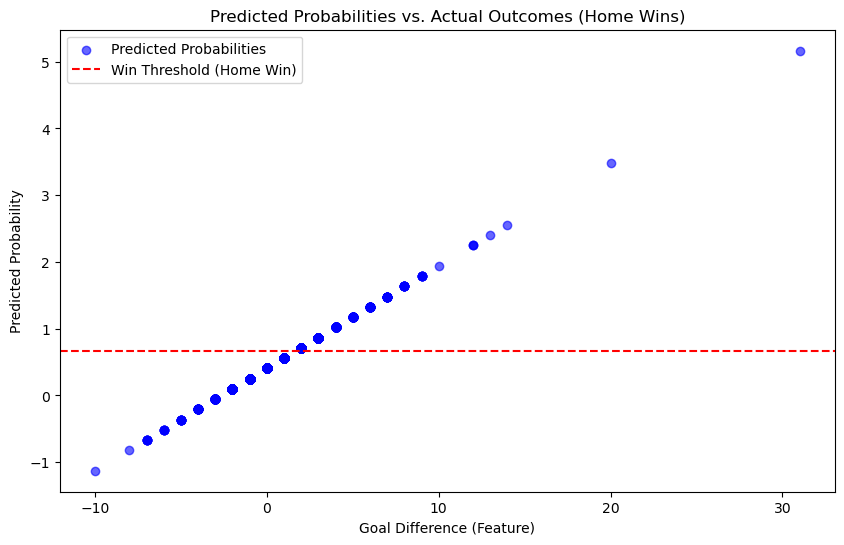

C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


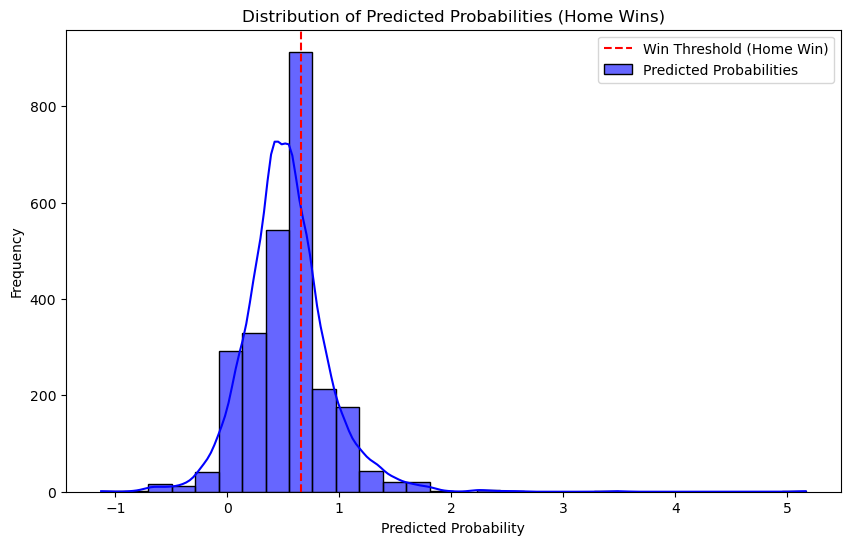

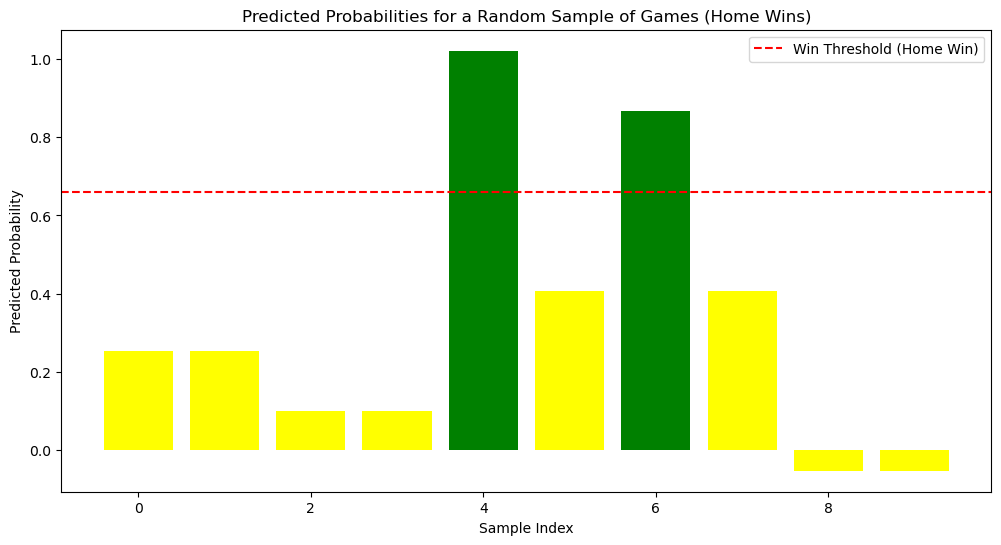

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

# Remove rows with NaNs
data_clean = data.dropna(subset=['difference'])

# Create the feature (X) and the target (y)
X = data_clean[['difference']]  # Feature is the 'difference' column
y = np.where(data_clean['difference'] > 0, 1, 0)  # 1 for home win, 0 for non-home win (loss or draw)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Map continuous predictions to classes (1 = Win, 0 = Non-Home Win)
y_pred_classified = np.where(y_pred > 0.66, 1, 0)  # Use 0.66 as the threshold for a home win

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred_classified)
print(f"Accuracy: {accuracy}")

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Scatter plot to visualize predicted probabilities vs actual outcomes focusing on home wins
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, color='blue', alpha=0.6, label='Predicted Probabilities')
plt.axhline(y=0.66, color='red', linestyle='--', label='Win Threshold (Home Win)')
plt.title('Predicted Probabilities vs. Actual Outcomes (Home Wins)')
plt.xlabel('Goal Difference (Feature)')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

# Histogram for predicted probabilities focusing on home wins
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=30, kde=True, color='blue', label='Predicted Probabilities', alpha=0.6)
plt.axvline(x=0.66, color='red', linestyle='--', label='Win Threshold (Home Win)')
plt.title('Distribution of Predicted Probabilities (Home Wins)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Bar plot for predicted probabilities for a sample of games focusing on home wins
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(np.arange(len(y_pred)), size=10, replace=False)  # Random sample of 10 games
sample_pred = y_pred[sample_indices]
plt.bar(np.arange(len(sample_pred)), sample_pred, color=['green' if p > 0.66 else 'yellow' for p in sample_pred])
plt.axhline(y=0.66, color='red', linestyle='--', label='Win Threshold (Home Win)')
plt.title('Predicted Probabilities for a Random Sample of Games (Home Wins)')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()


In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error

# Generate random predictions (0 or 1) with the same size as the test set
random_predictions = np.random.choice([0, 1], size=len(y_test))

# Evaluate accuracy of random predictions
random_accuracy = accuracy_score(y_test, random_predictions)
random_mse = mean_squared_error(y_test, random_predictions)

print(f"Random Prediction Accuracy: {random_accuracy}")
print(f"Random Prediction Mean Squared Error: {random_mse}")

# Compare with model's accuracy and MSE
print(f"Model Accuracy: {accuracy}")
print(f"Model Mean Squared Error: {mse}")


Random Prediction Accuracy: 0.5100875523410735
Random Prediction Mean Squared Error: 0.48991244765892655
Model Accuracy: 0.7974876284735439
Model Mean Squared Error: 0.12044686130617478
